# IMPORT DEPENDENCIES

In [1]:
# Add the parent directory of the current script to the system path
# to enable importing modules from that directory or its subdirectories.
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
# Import necessary modules and functions
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import geopandas as gpd
# Import custom modules and functions
from src.processing import read_outlets, join_watersheds2points, load_river_network, clip_river_network, insert_watershed_info, process_watershed_points
from src.snap_pour_point import read_flow_accumulation_tif, calculate_new_pour_point
from src.delineator import read_drainage_direction, calculate_upstream_v2  
from src.polygonize import raster_to_polygon, rasterize_array
from src.file_manager import create_results_directory

from configuration import OUTLETS, WATERSHEDS, MODE, FLOW_ACCUMULATION, DRAINAGE_DIRECTION, PIXEL2SEARCH, RIVERS, RESULTS, MAX_STRAHLER


In [3]:
"""
Main function for processing hydrological data given the instructions in configuration.py.
"""


create_results_directory(RESULTS)

points = read_outlets(OUTLETS)

points = points.loc[:2]

if MODE == "single":

    accum, pixel_size = read_flow_accumulation_tif(FLOW_ACCUMULATION)

    drainage_direction, tif_profile, dr_dir_src = read_drainage_direction(
        DRAINAGE_DIRECTION)

    river_vector = load_river_network(RIVERS)

    points_new = process_watershed_points(points, accum, pixel_size, drainage_direction, dr_dir_src,
                                            tif_profile, river_vector, MAX_STRAHLER, RESULTS)
    points_new["change_rate[%]"] = 100 * \
        (points_new["CalculatedArea[km2]"] -
            points_new["area[km2]"]) / points_new["area[km2]"]

elif MODE == "partial":
    points_labelled = join_watersheds2points(points, WATERSHEDS)

    unique_watershed_ids = points_labelled["Watershed_ID"].unique()

    points_new = pd.DataFrame()

    for watershed in unique_watershed_ids:
        print(
            f"Delineating the upstream area of the points in {watershed}...")

        filtered_points_labelled = points_labelled[points_labelled["Watershed_ID"] == watershed]

        accum, pixel_size = read_flow_accumulation_tif(
            os.path.join(FLOW_ACCUMULATION, watershed + '.tif'))

        drainage_direction, tif_profile, dr_dir_src = read_drainage_direction(
            os.path.join(DRAINAGE_DIRECTION, watershed + '.tif'))

        river_vector = load_river_network(
            os.path.join(RIVERS, watershed + '.geojson'))

        points_watershed, subbasin, river = process_watershed_points(filtered_points_labelled, accum, pixel_size, drainage_direction, dr_dir_src,
                                                    tif_profile, river_vector, MAX_STRAHLER, RESULTS)

        points_new = pd.concat(
            [points_new, points_watershed], ignore_index=True)
    points_new["change_rate[%]"] = 100 * \
        (points_new["CalculatedArea[km2]"] -
            points_new["area[km2]"]) / points_new["area[km2]"]


Delineating the upstream area of the points in TR02...
[+] Processing D02A006.
[+] Processing D02A031.
[+] Processing D02A041.


In [21]:
river.head()

,OBJECTID,adi,nehir_kod,hidrolojik,strahler,olcek_sini,nehir_turu,uzunluk,yatak_geni,egim,ortalama_k,korunan_al,baglanti,Havza_Id,Shape_Leng,geometry
8696,18706.0,Bilinmiyor,TR02NH049496,1,1,3,1,1113.9,1,17.9,558.2,1,2,TR02,0.011311,"LINESTRING Z (29.44841 40.54699 658.13000, 29...."
8766,18776.0,Bilinmiyor,TR02NH049975,2,2,3,1,294.4,1,9.9,443.6,1,2,TR02,0.003202,"LINESTRING Z (29.44066 40.55425 458.20300, 29...."
8790,18800.0,Bilinmiyor,TR02NH050097,2,2,3,1,93.5,1,11.6,423.5,1,2,TR02,0.000883,"LINESTRING Z (29.43791 40.55582 428.92750, 29...."
8794,18804.0,Bilinmiyor,TR02NH050147,2,2,3,1,310.7,1,9.5,403.3,1,2,TR02,0.003606,"LINESTRING Z (29.43749 40.55660 418.08310, 29...."
8797,18807.0,Kömürcü,TR02NH050169,2,3,3,1,353.2,1,6.2,377.6,1,2,TR02,0.003488,"LINESTRING Z (29.43398 40.55685 388.51990, 29...."


<AxesSubplot:>

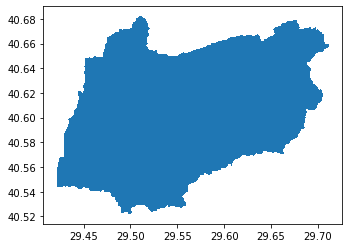

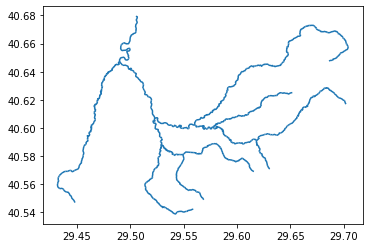

In [6]:
subbasin.plot()
river.plot()

In [27]:
import os
import simplekml

# Create an instance of Kml
kml = simplekml.Kml(open=1)

# Create a linestring with two points (ie. a line)
linestring = kml.newlinestring(name="River Segments")
linestring.extendeddata.newdata(name='birds', value=400, displayname="Bird Species")
linestring.coords = [(-122.364383,37.824664),(-122.364152,37.824322)]


# Save the KML
kml.save("test" + ".kml")

<AxesSubplot:>

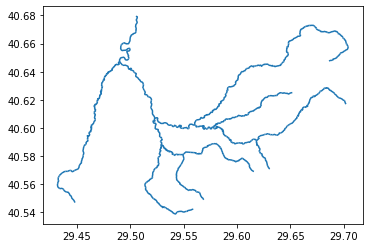

In [50]:
river.plot()

In [116]:
columns = river.columns

columns = [col for col in columns if col != "geometry"]

kml = simplekml.Kml(open=1)
for index, row in river.iterrows():
    linestring = kml.newlinestring(name= str(index))
    linestring.style.linestyle.color = simplekml.Color.hex("0000ff") 
    linestring.style.linestyle.width = 3  
    for col in columns:
        linestring.extendeddata.newdata(name=col, value=str(row[col]), displayname=col)
        linestring.coords = row["geometry"].coords[:]
    
kml.save("test_river" + ".kml")
    

In [118]:
row = subbasin.loc[0]

In [119]:
kml = simplekml.Kml(open=1)

pol = kml.newpolygon(name=str(index))
pol.outerboundaryis = list(zip(*row.geometry.exterior.coords.xy))

pol.style.linestyle.color = simplekml.Color.white
pol.style.linestyle.width = 2
pol.style.polystyle.color = simplekml.Color.changealphaint(75, simplekml.Color.black)
pol.extendeddata.newdata(name=col, value=str(row[col]), displayname=col)
kml.save("poly.kml")

KeyError: 'Shape_Leng'

In [120]:
col

'Shape_Leng'

In [121]:
def geopandas2KML(gpd, kml_save_path, vector_type):
    # redtrieve the name of the file without extension\
    kml_name = os.path.basename(kml_save_path).split(".")[0]

    columns = gpd.columns
    columns = [col for col in columns if col != "geometry"]

    kml = simplekml.Kml(open=1)
    if vector_type == "linestring":
        for index, row in gpd.iterrows():
            linestring = kml.newlinestring(name= kml_name)
            linestring.style.linestyle.color = simplekml.Color.hex("0000ff") 
            linestring.style.linestyle.width = 3  
            for col in columns:
                linestring.extendeddata.newdata(name=col, value=row[col], displayname=col)
                linestring.coords = row["geometry"].coords[:]

    elif vector_type == "polygon":
        for index, row in gpd.iterrows():
            pol = kml.newpolygon(name= kml_name)
            pol.outerboundaryis = list(zip(*row.geometry.exterior.coords.xy))
            pol.style.linestyle.color = simplekml.Color.white
            pol.style.linestyle.width = 2
            pol.style.polystyle.color = simplekml.Color.changealphaint(75, simplekml.Color.black)
            for col in columns:
                pol.extendeddata.newdata(name=col, value=row[col], displayname=col)

    kml.save(kml_save_path)


In [122]:
geopandas2KML(subbasin, "test_function.kml", "polygon")

In [123]:

river

,OBJECTID,adi,nehir_kod,hidrolojik,strahler,olcek_sini,nehir_turu,uzunluk,yatak_geni,egim,ortalama_k,korunan_al,baglanti,Havza_Id,Shape_Leng,geometry
8696,18706.0,Bilinmiyor,TR02NH049496,1,1,3,1,1113.9,1,17.9,558.2,1,2,TR02,0.011311,"LINESTRING Z (29.44841 40.54699 658.13000, 29...."
8766,18776.0,Bilinmiyor,TR02NH049975,2,2,3,1,294.4,1,9.9,443.6,1,2,TR02,0.003202,"LINESTRING Z (29.44066 40.55425 458.20300, 29...."
8790,18800.0,Bilinmiyor,TR02NH050097,2,2,3,1,93.5,1,11.6,423.5,1,2,TR02,0.000883,"LINESTRING Z (29.43791 40.55582 428.92750, 29...."
8794,18804.0,Bilinmiyor,TR02NH050147,2,2,3,1,310.7,1,9.5,403.3,1,2,TR02,0.003606,"LINESTRING Z (29.43749 40.55660 418.08310, 29...."
8797,18807.0,Kömürcü,TR02NH050169,2,3,3,1,353.2,1,6.2,377.6,1,2,TR02,0.003488,"LINESTRING Z (29.43398 40.55685 388.51990, 29...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,19856.0,Kara,TR02NH056146,2,4,2,1,551.4,1,0.6,61.1,1,2,TR02,0.005823,"LINESTRING Z (29.47771 40.63777 62.71950, 29.4..."
9871,19881.0,Yalak,TR02NH056248,3,6,2,1,102.8,1,0.0,54.7,2,2,TR02,0.001037,"LINESTRING Z (29.50426 40.63927 51.31340, 29.5..."
9880,19890.0,Yalak,TR02NH056300,3,6,2,1,285.8,1,3.4,53.1,2,2,TR02,0.003156,"LINESTRING Z (29.50360 40.63999 57.99470, 29.5..."
9883,19893.0,Kara,TR02NH056312,3,4,2,1,441.1,1,0.2,59.0,1,2,TR02,0.004522,"LINESTRING Z (29.48129 40.64011 59.39360, 29.4..."


In [126]:
subbasin.columns

Index(['geometry', 'CalculatedArea[km2]'], dtype='object')

In [128]:
import geopandas
from shapely.geometry import MultiPoint
d = {
    "col1": ["name1", "name2"],
    "geometry": [
        MultiPoint([(1, 2), (3, 4)]),
        MultiPoint([(2, 1), (0, 0)]),
    ],
}
gdf = geopandas.GeoDataFrame(d, crs=4326)


In [130]:
gdf

,col1,geometry
0,name1,"MULTIPOINT (1.00000 2.00000, 3.00000 4.00000)"
1,name2,"MULTIPOINT (2.00000 1.00000, 0.00000 0.00000)"


In [137]:
gdf.loc[1].explode(ignore_index=True)

0                    name2
1    MULTIPOINT (2 1, 0 0)
Name: 1, dtype: object

In [ ]:
gdf.loc[0]

In [3]:
create_results_directory(RESULTS)

points = read_outlets(OUTLETS)

if MODE == "single":

    accum, pixel_size = read_flow_accumulation_tif(FLOW_ACCUMULATION)

    drainage_direction, tif_profile, dr_dir_src = read_drainage_direction(DRAINAGE_DIRECTION)

    river_vector = load_river_network(RIVERS)   
    
    points_new = process_watershed_points(points, accum, pixel_size, drainage_direction, dr_dir_src,
                            tif_profile, river_vector, MAX_STRAHLER, RESULTS)
    
    points_new["change_rate[%]"] = 100 * (points_new["CalculatedArea[km2]"] - points_new["area[km2]"]) / points_new["area[km2]"]
    
elif MODE == "partial":

    points_labelled = join_watersheds2points(points, WATERSHEDS)
    unique_watershed_ids = points_labelled["Watershed_ID"].unique()
    points_new = pd.DataFrame()
    for watershed in unique_watershed_ids:
        print(f"{watershed}")
        filtered_points_labelled  = points_labelled[points_labelled["Watershed_ID"] == watershed]    
        accum, pixel_size = read_flow_accumulation_tif(os.path.join(FLOW_ACCUMULATION, watershed + '.tif'))

        drainage_direction, tif_profile, dr_dir_src = read_drainage_direction(os.path.join(DRAINAGE_DIRECTION, watershed + '.tif'))

        river_vector = load_river_network(os.path.join(RIVERS, watershed + '.geojson'))   
        
        points_watershed = process_watershed_points(filtered_points_labelled, accum, pixel_size, drainage_direction, dr_dir_src,
                                tif_profile, river_vector, MAX_STRAHLER, RESULTS) 
        
        points_new = pd.concat([points_new, points_watershed], ignore_index=True)
        
    points_new["change_rate[%]"] = 100 * (points_new["CalculatedArea[km2]"] - points_new["area[km2]"]) / points_new["area[km2]"]
# try:
#     points_new.to_csv(os.path.join(RESULTS, 'report_secondRUN.csv'), encoding="windows-1254")
# except UnicodeEncodeError:
#     points_new.to_csv(os.path.join(RESULTS, 'report_secondRUN.csv'), encoding="utf8")

[b'id;name;area[km2];long;lat\r\n']


TypeError: cannot use a string pattern on a bytes-like object

In [10]:
import fiona


In [1]:
from datetime import datetime

In [6]:
    
    # Get current date and time
    now = datetime.now()

    # Format to dd/mm/YYYY HH:SS
    formatted_datetime = now.strftime("%d%m%Y_%H%M")

In [8]:
datetime.now().strftime("%d%m%Y_%H%M")

'20092023_1554'

# DEBUGGING POLYGONIZE

In [ ]:


def calculate_upstream_v1(drainage_direction, pour_point_coords):
    """
    Calculate the upstream area based on the given drainage direction and pour point coordinates.

    Parameters:
    - drainage_direction: numpy.ndarray
        A 2D array representing the drainage direction. Each pixel indicates the direction in which water flows.
    - pour_point_coords: tuple (row, column)
        The row and column indices of the pour point, which is the starting point for calculating the upstream area.

    Returns:
    - upstream_area: numpy.ndarray
        A boolean array indicating the pixels that belong to the upstream area.

    The function uses a recursive algorithm to traverse upstream from the pour point, following the drainage direction.
    It marks the pixels that contribute flow to the pour point as part of the upstream area.

    Note:
    - The drainage direction values should follow the D8 convention (values 1 to 8 representing the eight directions).
    - The pour point coordinates should be within the boundaries of the drainage direction array.
    """

    # Create an empty array with the same shape as the drainage direction
    upstream_area = np.zeros_like(drainage_direction, dtype=bool)

    # Get the row and column indices of the pour point
    row, col = pour_point_coords

    # Define the D8 offsets for the eight directions
    offsets = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

    # Recursive function to calculate upstream area
    def traverse_upstream(r, c):
        # Check if the current pixel is within the boundaries of the array
        if r < 0 or r >= drainage_direction.shape[0] or c < 0 or c >= drainage_direction.shape[1]:
            return

        # Check if the current pixel is already marked as part of the upstream area
        if upstream_area[r, c]:
            return

        # Mark the current pixel as part of the upstream area
        upstream_area[r, c] = True

        # Iterate over the eight directions
        for direction in range(8):
            # Get the offset for the corresponding direction
            offset = offsets[direction]

            # Move to the next pixel based on the offset
            next_r = r + offset[0]
            next_c = c + offset[1]

            # Check if the next pixel drains into the current pixel
            if next_r >= 0 and next_r < drainage_direction.shape[0] and next_c >= 0 and next_c < drainage_direction.shape[1]:
                if (drainage_direction[next_r, next_c] - 1) % 8 == (7 + direction - 4) % 8:
                    # Recursively traverse upstream from the next pixel
                    traverse_upstream(next_r, next_c)

    # Start traversing upstream from the pour point
    traverse_upstream(row, col)

    return upstream_area.astype(int)


In [ ]:
from numba import njit
@njit
def calculate_upstream_v2(drainage_direction, pour_point_coords):
    """
    Calculate the upstream area based on the given drainage direction and pour point coordinates.

    Parameters:
    - drainage_direction: numpy.ndarray
        A 2D array representing the drainage direction. Each pixel indicates the direction in which water flows.
    - pour_point_coords: tuple (row, column)
        The row and column indices of the pour point, which is the starting point fo r calculating the upstream area.

    Returns:
    - upstream_area: numpy.ndarray
        A binary array indicating the pixels that belong to the upstream area (1 for upstream, 0 for other pixels).

    The function uses a stack-based iterative algorithm to traverse upstream from the pour point, following the
    drainage direction. It marks the pixels that contribute flow to the pour point as part of the upstream area.

    Note:
    - The drainage direction values should follow the D8 convention (values 1 to 8 representing the eight directions).
    - The pour point coordinates should be within the boundaries of the drainage direction array.
    - The function utilizes the `numba` library's `njit` decorator for improved performance.
    """

    # Create an empty array with the same shape as the drainage direction
    upstream_area = np.zeros_like(drainage_direction, dtype=np.int8)

    # Get the row and column indices of the pour point
    row, col = pour_point_coords

    # Define the D8 offsets for the eight directions
    offsets = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    offsets = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

    # Create a stack to store the pixel coordinates
    stack = [(row, col)]

    # Mark the pour point as part of the upstream area
    upstream_area[row, col] = 1

    # Iterate until the stack is empty
    while stack:
        r, c = stack.pop()
        print("r, c", r, c)

        # Iterate over the eight directions
        for direction in range(8):
            offset = offsets[direction]
            next_r = r + offset[0]
            next_c = c + offset[1]

            # Check if the next pixel is within the array boundaries
 
            if 0 <= next_r < drainage_direction.shape[0] and 0 <= next_c < drainage_direction.shape[1]:
                # if (drainage_direction[next_r, next_c] - 1) % 8 == (7 + direction - 4) % 8:
                if (drainage_direction[next_r, next_c] - 1) % 8 == (7 + direction - 4) % 8:
                    print(next_r, next_c)
                    upstream_area[next_r, next_c] = 1
                    stack.append((next_r, next_c))
        print("Stack:", len(stack))
    return upstream_area

In [ ]:
create_results_directory(RESULTS)

points = read_outlets(OUTLETS)
points_labelled = join_watersheds2points(points, WATERSHEDS)
unique_watershed_ids = points_labelled["Watershed_ID"].unique()
points = points_labelled.copy()


for index, row in points.iterrows():
    
    # if row.id == "D25A039":
    if row.id == "D25A045": 
    # if row.id == "D25A044": 
        print(f"[+] Processing {row.id}.")   
        # Calculate new pour point
        new_pour_point = calculate_new_pour_point(accum, pixel_size, (row.long, row.lat), 1)
        new_pour_point_xy = dr_dir_src.index(new_pour_point[0], new_pour_point[1])

        # Extract watersheds
        upstream_area = calculate_upstream_v2(drainage_direction, new_pour_point_xy)
        rasterized_array = rasterize_array(upstream_area, tif_profile)

        # Save polygon and line as JSON
        subbasin = raster_to_polygon(rasterized_array, save_polygon=True, 
                                        polygon_save_path=os.path.join(RESULTS, "watershed", str(row.id) + "_basin"))

        # Clip rivers
        clipped_river_network, feedback = clip_river_network(river_vector, subbasin, 
                                                            max_strahler_order=MAX_STRAHLER, 
                                                            line_save_path=os.path.join(RESULTS, "river", str(row.id) + "_river"))

        # Insert watershed delineation information into the points table
        points_copy = insert_watershed_info(points_copy, row, new_pour_point, 
                                            subbasin["CalculatedArea[km2]"][0], feedback)

In [ ]:
subbasin.plot()

In [ ]:
points_copy

In [ ]:
_MODE = "partial"
if MODE == "partial":
    points_labelled = join_watersheds2points(points, WATERSHEDS)
    unique_watershed_ids = points_labelled["Watershed_ID"].unique()
    for watershed in unique_watershed_ids[:1]:
        filtered_points_labelled  = points_labelled[points_labelled["Watershed_ID"] == watershed] 
    

In [ ]:
watershed

In [ ]:
for index, row in points.iterrows():
    print(f"[+] Proccessing {row.id}.")
    # Calculate new pour point
    new_pour_point = calculate_new_pour_point(accum, pixel_size, (row.long, row.lat), PIXEL2SEARCH)
    new_pour_point_xy = dr_dir_src.index(new_pour_point[0], new_pour_point[1])
    # Extract watersheds
    upstream_area = calculate_upstream_v2(drainage_direction, new_pour_point_xy)
    rasterized_array = rasterize_array(upstream_area, tif_profile)
    # Save polygon and line as JSON
    subbasin = raster_to_polygon(rasterized_array, save_polygon=True, polygon_save_path=os.path.join(RESULTS,"watershed", str(row.id)+"_basin"))
    # Clip rivers

    clipped_river_network, feedback = clip_river_network(river_vector, subbasin, max_strahler_order = MAX_STRAHLER, line_save_path=os.path.join(RESULTS,"river", str(row.id)+"_river"))

    # Insert watershed delienation information into the points table
    points_copy = insert_watershed_info(points_copy, row, new_pour_point, subbasin["CalculatedArea[km2]"][0], feedback)


In [ ]:
process_watershed_points(points, accum, pixel_size, drainage_direction, dr_dir_src,
                            tif_profile, river_vector, MAX_STRAHLER, RESULTS)

In [ ]:
type(dr_dir_src)

In [ ]:
points

In [ ]:
def loop_over_points():
    for index, row in points.iterrows():
   
        # Calculate new pour point
        new_pour_point = calculate_new_pour_point(accum, pixel_size, (row.long, row.lat), PIXEL2SEARCH)
        new_pour_point_xy = dr_dir_src.index(new_pour_point[0], new_pour_point[1])
        # Extract watersheds
        upstream_area = calculate_upstream_v2(drainage_direction, new_pour_point_xy)
        rasterized_array = rasterize_array(upstream_area, tif_profile)
        # Save polygon and line as JSON
        subbasin = raster_to_polygon(rasterized_array, save_polygon=True, polygon_save_path=os.path.join(RESULTS,"watershed", str(row.id)+"_basin"))
        # Clip rivers
        clipped_river_network = clip_river_network(river_vector, subbasin, max_strahler_order = MAX_STRAHLER, line_save_path=os.path.join(RESULTS,"river", str(row.id)+"_river"))


In [ ]:

for index, row in points.iterrows():
   
    # Calculate new pour point
    new_pour_point = calculate_new_pour_point(accum, pixel_size, (row.long, row.lat), PIXEL2SEARCH)
    new_pour_point_xy = dr_dir_src.index(new_pour_point[0], new_pour_point[1])
    # Extract watersheds
    upstream_area = calculate_upstream_v2(drainage_direction, new_pour_point_xy)
    rasterized_array = rasterize_array(upstream_area, tif_profile)
    # Save polygon and line as JSON
    subbasin = raster_to_polygon(rasterized_array, save_polygon=True, polygon_save_path=os.path.join(RESULTS,"watershed", str(row.id)+"_basin"))
    # Clip rivers
    clipped_river_network = clip_river_network(river_vector, subbasin, max_strahler_order = MAX_STRAHLER, line_save_path=os.path.join(RESULTS,"river", str(row.id)+"_river"))
      

In [ ]:
def read_drainage_direction(drainage_direction_path, outlets=None, pour_point_coord=None):
    """
    Reads the drainage direction data from a TIFF file.

    Parameters:
        drainage_direction_path (str): File path of the drainage direction TIFF.
        outlets (geopandas.GeoDataFrame, optional): GeoDataFrame containing outlets with 'long' and 'lat' columns.
            Each outlet's coordinates will be used as pour points to locate specific cells in the TIFF.
        pour_point_coord (tuple, optional): Coordinates of the pour point in the format (x, y).
            The pour point coordinates are used to locate the specific cell in the TIFF.

    Returns:
        tuple: A tuple containing the drainage direction data as a NumPy array,
               the pour point coordinates in the TIFF, and the metadata profile of the TIFF.

    Notes:
        - The function uses the rasterio library to read the TIFF file.
        - The drainage direction data is typically represented as an array where each
          cell represents the direction of flow.
        - If `pour_point_coord` is provided, it is used as the pour point to locate the specific cell in the TIFF.
        - If `outlets` is provided, each outlet's coordinates are used as pour points to locate specific cells in the TIFF.
        - The metadata profile contains information about the TIFF such as its spatial
          reference system, resolution, and other properties.

    Raises:
        ValueError: If both `outlets` and `pour_point_coord` are provided at the same time, or if `outlets` is not a GeoDataFrame.
    """
    if outlets is not None and pour_point_coord is not None:
        raise ValueError("Only one of 'outlets' or 'pour_point_coord' should be provided, not both.")
    if outlets is not None and (outlets.empty or outlets is None):
        raise ValueError("'outlets' GeoDataFrame is empty or None.")
    if outlets is not None and not isinstance(outlets, gpd.GeoDataFrame):
        raise ValueError("'outlets' must be a GeoDataFrame.")

    with rasterio.open(drainage_direction_path) as src:
        drainage_direction = src.read(1)
        profile = src.profile
        if pour_point_coord:
            pour_point_xy = src.index(pour_point_coord[0], pour_point_coord[1])
            return drainage_direction, pour_point_xy, profile
        if outlets is not None:
            for index, row in outlets.iterrows():
                pour_point_coord = row.long, row.lat
                pour_point_xy = src.index(pour_point_coord[0], pour_point_coord[1])
                outlets.loc[index, 'pour_point_x'] = int(pour_point_xy[0])
                outlets.loc[index, 'pour_point_y'] = int(pour_point_xy[1])
            return drainage_direction, outlets, profile

# SET THE PARAMETERS

In [ ]:
# Number of neighboring pixels to consider 
# in search of the neigboring pixel with the highest flow accumualtion
PIXEL2SEARCH = 1

# CALCULATION

In [ ]:
path = '../data/flow_accumulation_TR.tif'
coord = (28.864, 40.130) 
coord = (28.963, 40.118) 

data, pixel_size = read_flow_accumulation_tif(path)
new_pour_point = calculate_new_pour_point(data, pixel_size, coord, PIXEL2SEARCH)
print(new_pour_point)

In [ ]:
drainage_direction_path = "../data/drainage_direction_TR.tif"
dr_dir, tif_profile, dr_dir_src = read_drainage_direction(drainage_direction_path)
pour_point_xy  = dr_dir_src.index(new_pour_point[0, new_pour_point[1]])
# Calculate upstream area
upstream_area = calculate_upstream_v2(dr_dir, pour_point_xy)

rasterized_array = rasterize_array(upstream_area, tif_profile, )
subbasin = raster_to_polygon(rasterized_array, save_polygon=False, polygon_save_path="output/polygon")

In [ ]:
subbasin.plot()

In [ ]:
watershed_id = "TR03"

In [ ]:
river_vector = load_river_network(watershed_id) 

In [ ]:
clipped_river_network = clip_river_network(river_vector, subbasin, 'output/river.geojson')

# TEST

## Read points

In [ ]:
points = read_outlets(OUTLETS)

In [ ]:
points.plot()

In [ ]:
points_labelled = join_watersheds2points(points, WATERSHEDS)
unique_watershed_ids = points_labelled["Watershed_ID"].unique()
for watershed in unique_watershed_ids[:1]:
    filtered_points_labelled  = points_labelled[points_labelled["Watershed_ID"] == watershed] 

In [ ]:
for watershed in unique_watershed_ids[:1]:
    filtered_points_labelled  = points_labelled[points_labelled["Watershed_ID"] == watershed] 

In [ ]:
filtered_points_labelled

In [ ]:
for index, row in filtered_points_labelled.iterrows():
    coord = [row["long"], row["lat"]]
    
    
    

In [ ]:
points = read_outlets(OUTLETS)

# if MODE == "single":
    